# INF8245E: Machine Learning | Assignment #2

**Louis Plessis (1933334)** | 24 October 2021

# 1. Linear Classification and Nearest Neighbour Classification

## 1.1. Generating 2 classes with 20 features each

In [1]:
import pandas as pd
import numpy as np

DS1_m_0 = pd.read_csv("DS1_m_0.txt", header=None)
DS1_m_0 = DS1_m_0.drop(columns=[20])
DS1_m_0 = np.array(DS1_m_0).flatten()

DS1_m_1 = pd.read_csv("DS1_m_1.txt", header=None)
DS1_m_1 = DS1_m_1.drop(columns=[20])
DS1_m_1 = np.array(DS1_m_1).flatten()

DS1_Cov = pd.read_csv("DS1_Cov.txt", header=None)
DS1_Cov = DS1_Cov.drop(columns=[20])
DS1_Cov = DS1_Cov.to_numpy()

#Generate 2000 examples
data_positive = np.random.multivariate_normal(DS1_m_1, DS1_Cov, 2000)
data_negative = np.random.multivariate_normal(DS1_m_0, DS1_Cov, 2000)

#Labels
data_positive = np.column_stack((data_positive, np.ones(2000)))
data_negative = np.column_stack((data_negative, np.zeros(2000)))

data = np.concatenate((data_positive, data_negative))

#Shuffling 
np.random.shuffle(data)

#20% test, 20% validation, 60% train
test = pd.DataFrame(data[0:800])
valid = pd.DataFrame(data[800:1600])
train = pd.DataFrame(data[1600:4000])

In [2]:
#Export to CSV
test.to_csv("DS1_test.txt",index=False, header=False)
valid.to_csv("DS1_valid.txt",index=False, header=False)
train.to_csv("DS1_train.txt",index=False, header=False)

## 1.2. GDA model

In [3]:
def GDA(train, test):    
    train_positive = train[train[20]==1]
    train_positive = train_positive.drop(columns=[20])

    train_negative = train[train[20]==0]
    train_negative = train_negative.drop(columns=[20])

    y = test[20]

    train = train.drop(columns=[20])
    train = train.to_numpy()

    test = test.drop(columns=[20])
    test = test.to_numpy()

    m1 = np.array(train_positive.mean())
    m0 = np.array(train_negative.mean())

    cov_matrix_positive = np.array(train_positive - m1)
    cov_matrix_negative = np.array(train_negative - m0)

    s0 = np.dot(cov_matrix_negative.T, cov_matrix_negative)
    s1 = np.dot(cov_matrix_positive.T, cov_matrix_positive)

    cov_matrix = (s0+s1)  / (len(train_negative)+len(train_positive))

    cov_inv_matrix = np.linalg.inv(cov_matrix)

    prob_positive = len(train_positive) / (len(train_negative)+len(train_positive))
    prob_negative = len(train_negative) / (len(train_negative)+len(train_positive))

    w0 = -np.dot(m0.T, np.dot(cov_inv_matrix,m0))/2 + np.dot(m1.T, np.dot(cov_inv_matrix,m1))/2 + np.log(prob_negative/prob_positive)
    w1 = np.dot(cov_inv_matrix, m0-m1)

    #GDA model
    a = np.dot(test, w1.T) + w0
    sigma = 1 / ( 1 + np.exp(-a) )

    for i in range(len(sigma)):
        if(sigma[i]>(1/2)):
            sigma[i]=0
        else:
            sigma[i]=1

    #CONFUSION MATRIX
    tp,fp,fn,tn = 0,0,0,0

    for i in range(len(y)):
        prediction = sigma[i]
        actual = y[i]

        if prediction==1 and prediction==actual:
            tp +=1
        elif prediction==1 and prediction!=actual:
            fp += 1
        elif prediction==0 and prediction!=actual:
            fn += 1
        elif prediction==0 and prediction==actual:
            tn += 1

    confusion_matrix = [[tp,fp],[fn,tn]]

    #Accuracy = [number of true / total number]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    print("********************** Accuracy *********************")
    print("\nBest fit accuracy achieved by the classifier: ", accuracy)
    
    print("\n\n**************** Learnt coefficients ****************")
    print("\nConfusion matrix: ", confusion_matrix)
    print("\nw0: ", w0)
    print("w1: ", w1)

In [4]:
GDA(train, test)

********************** Accuracy *********************

Best fit accuracy achieved by the classifier:  0.96125


**************** Learnt coefficients ****************

Confusion matrix:  [[401, 13], [18, 368]]

w0:  25.789362676542982
w1:  [ 13.60686897  -8.0411546   -5.60977675  -2.8935371   -8.97023036
  -4.08073642  16.07587757 -22.55605012 -27.29309626   8.51634691
 -12.59101743 -11.85074017  14.80234166  12.27139296  -5.28310131
  12.23229351  27.81066999  -6.38890567  -0.62972679  -4.75409964]


## 1.3. k-NN

### Validation accuracy for different values of k

In [5]:
import matplotlib.pyplot as plt

def k_NN(x_train, x_valid, y_valid, k_max):

    best_accuracy = 0
    accuracies = []

    for k in range(1,k_max):
        tp,fp,fn,tn = 0,0,0,0

        for j in range(len(y_valid)):

            distances = np.power(np.linalg.norm(x_train-x_valid[j], None, 1),2)
            neighbourhood = distances.argsort()
            k_nearest_neighbours = neighbourhood[:k]
            
            if(x_train[k_nearest_neighbours,19].sum() > 0):
                prediction=1
            else:
                prediction=0

            actual = y_valid[j]

            if prediction==1 and prediction==actual:
                tp +=1
            elif prediction==1 and prediction!=actual:
                fp += 1
            elif prediction==0 and prediction!=actual:
                fn += 1
            elif prediction==0 and prediction==actual:
                tn += 1

        accuracy = (tp+tn)/(tp+tn+fp+fn)
        accuracies.append(accuracy)

        if(accuracy > best_accuracy):
            best_accuracy = accuracy
            confusion_matrix = [[tp,fp],[fn,tn]]
            best_k = k
            
    plt.plot(list(range(1,k_max)), accuracies)
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.show()
    
    print('Best fit accuracy:', best_accuracy, 'when k = ', best_k)

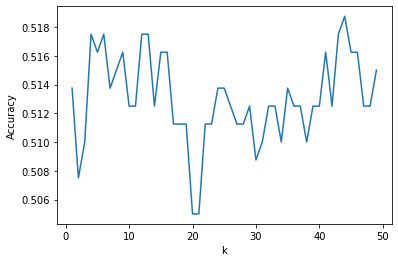

Best fit accuracy: 0.51875 when k =  44


In [6]:
y_valid = valid[20]

x_valid = valid.drop(columns=[20])
x_valid = x_valid.to_numpy()

x_train = train.drop(columns=[20])
x_train = x_train.to_numpy()

k_NN(x_train, x_valid, y_valid, 50)

This classifier seems to perform worse than GDA overall ($\sim0.55$ accuracy instead of $\sim0.95$ for GDA). Some specific values of k seem to perform better than others, due to the low stability of this method. However, the difference is very small as the accuracy stays around $55\%$.

## 1.4. Mixture of 3 Gaussians

In [7]:
#Positive: DS2-c1
#Negative: DS2-c2

#mean arrays
DS2_c1_m1 = pd.read_csv("DS2_c1_m1.txt", header=None)
DS2_c1_m1 = DS2_c1_m1.drop(columns=[20])
DS2_c1_m1 = np.array(DS2_c1_m1).flatten()

DS2_c1_m2 = pd.read_csv("DS2_c1_m2.txt", header=None)
DS2_c1_m2 = DS2_c1_m2.drop(columns=[20])
DS2_c1_m2 = np.array(DS2_c1_m2).flatten()

DS2_c1_m3 = pd.read_csv("DS2_c1_m3.txt", header=None)
DS2_c1_m3 = DS2_c1_m3.drop(columns=[20])
DS2_c1_m3 = np.array(DS2_c1_m3).flatten()

DS2_c2_m1 = pd.read_csv("DS2_c2_m1.txt", header=None)
DS2_c2_m1 = DS2_c2_m1.drop(columns=[20])
DS2_c2_m1 = np.array(DS2_c2_m1).flatten()

DS2_c2_m2 = pd.read_csv("DS2_c2_m2.txt", header=None)
DS2_c2_m2 = DS2_c2_m2.drop(columns=[20])
DS2_c2_m2 = np.array(DS2_c2_m2).flatten()

DS2_c2_m3 = pd.read_csv("DS2_c2_m3.txt", header=None)
DS2_c2_m3 = DS2_c2_m3.drop(columns=[20])
DS2_c2_m3 = np.array(DS2_c2_m3).flatten()

#covariance matrices
DS2_Cov1 = pd.read_csv("DS2_Cov1.txt", header=None)
DS2_Cov1 = DS2_Cov1.drop(columns=[20])
DS2_Cov1 = DS2_Cov1.to_numpy()

DS2_Cov2 = pd.read_csv("DS2_Cov2.txt", header=None)
DS2_Cov2 = DS2_Cov2.drop(columns=[20])
DS2_Cov2 = DS2_Cov2.to_numpy()

DS2_Cov3 = pd.read_csv("DS2_Cov3.txt", header=None)
DS2_Cov3 = DS2_Cov3.drop(columns=[20])
DS2_Cov3 = DS2_Cov3.to_numpy()

mix_split_1 = int(2000*0.1)
mix_split_2 = int(2000*0.42)
mix_split_3 = int(2000*0.48)

pos1 = np.random.multivariate_normal(DS2_c1_m1, DS2_Cov1, mix_split_1)
pos2 = np.random.multivariate_normal(DS2_c1_m2, DS2_Cov2, mix_split_2)
pos3 = np.random.multivariate_normal(DS2_c1_m3, DS2_Cov3, mix_split_3)

neg1 = np.random.multivariate_normal(DS2_c2_m1, DS2_Cov1, mix_split_1)
neg2 = np.random.multivariate_normal(DS2_c2_m1, DS2_Cov2, mix_split_2)
neg3 = np.random.multivariate_normal(DS2_c2_m1, DS2_Cov3, mix_split_3)

#Labels
pos1 = np.column_stack((pos1, np.ones(mix_split_1)))
pos2 = np.column_stack((pos2, np.ones(mix_split_2)))
pos3 = np.column_stack((pos3, np.ones(mix_split_3)))

neg1 = np.column_stack((neg1, np.zeros(mix_split_1)))
neg2 = np.column_stack((neg2, np.zeros(mix_split_2)))
neg3 = np.column_stack((neg3, np.zeros(mix_split_3)))

data1 = np.concatenate((pos1, neg1))
data2 = np.concatenate((pos2, neg2))
data3 = np.concatenate((pos3, neg3))

#Shuffling 
np.random.shuffle(data1)
np.random.shuffle(data2)
np.random.shuffle(data3)

#20% test, 20% validation, 60% train
split1 = int(4000*0.1)
split2 = int(split1 + 4000*0.42)
split3 = int(split2 + 4000*0.48)

test1 = pd.DataFrame(data1[0:int(len(data1)*0.2)])
test2 = pd.DataFrame(data2[0:int(len(data2)*0.2)])
test3 = pd.DataFrame(data3[0:int(len(data3)*0.2)])

valid1 = pd.DataFrame(data1[int(len(data1)*0.2):int(len(data1)*0.4)])
valid2 = pd.DataFrame(data2[int(len(data2)*0.2):int(len(data2)*0.4)])
valid3 = pd.DataFrame(data3[int(len(data3)*0.2):int(len(data3)*0.4)])

train1 = pd.DataFrame(data1[int(len(data1)*0.4):int(len(data1))])
train2 = pd.DataFrame(data2[int(len(data2)*0.4):int(len(data2))])
train3 = pd.DataFrame(data3[int(len(data3)*0.4):int(len(data3))])

test = pd.DataFrame(np.concatenate((test1, test2, test3)))
valid = pd.DataFrame(np.concatenate((valid1, valid2, valid3)))
train = pd.DataFrame(np.concatenate((train1, train2, train3)))

In [8]:
#Export to CSV
test.to_csv("DS2_test.txt",index=False, header=False)
valid.to_csv("DS2_valid.txt",index=False, header=False)
train.to_csv("DS2_train.txt",index=False, header=False)

## 1.5. DS2

### 1.5.1. Estimating the parameters of the GDA model using the maximum likelihood approach

In [9]:
GDA(train, test)

********************** Accuracy *********************

Best fit accuracy achieved by the classifier:  0.585


**************** Learnt coefficients ****************

Confusion matrix:  [[220, 157], [175, 248]]

w0:  -0.4217621867705717
w1:  [-0.08871179  0.02592391 -0.02680609 -0.01310074  0.2177535   0.04407805
 -0.18204516  0.10733856  0.1084168   0.10929533  0.15241791  0.04421081
  0.09548686 -0.02793171 -0.16387901  0.04429896 -0.00151807 -0.02090078
 -0.14322817 -0.00731808]


### 1.5.2., 1.5.3. k-NN

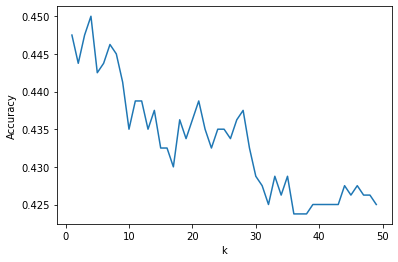

Best fit accuracy: 0.45 when k =  4


In [10]:
y_valid = valid[20]

x_valid = valid.drop(columns=[20])
x_valid = x_valid.to_numpy()

x_train = train.drop(columns=[20])
x_train = x_train.to_numpy()

k_NN(x_train, x_valid, y_valid, 50)

This classifier seems to perform worse than GDA overall ($\sim0.45$ accuracy instead of $\sim0.95$ for GDA). Some specific values of k seem to perform better than others, due to the low stability of this method. However, the difference is very small as the accuracy stays around $45\%$.

## 1.6. Similarities and differences between the performance of both classifiers

With both DS1 and DS2, GDA seems to perform better than k-NN. Also, k-NN behaves in the same way with both datasets (i.e. some values of k perform better than others, with no visible pattern). However, best fit accuracy for k-NN is found earlier with DS2 (low k value) than with DS1 $(k\sim30)$. Besides, DS1 seems to perform better than DS2 overall ($\sim95\%$ and $\sim55\%$ accuracies for DS1, $\sim62\%$ and $\sim45\%$ accuracies for DS2).

# 2. MNIST Handwritten Digits Classification

In [91]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#0-50000 = train, 50000-60000 = valid
x_valid = x_train[50000:60000]
y_valid = y_train[50000:60000]

x_train = x_train[0:50000]
y_train = y_train[0:50000]

#Flattening to 784 features
x_train_flattened = []
x_valid_flattened = []

for i in range(len(x_train)):
    x_train_flattened.append(x_train[i].flatten())
    
for i in range(len(x_valid)):
    x_valid_flattened.append(x_valid[i].flatten())

#Normalizing
x_train = np.array(x_train_flattened)/255
x_valid = np.array(x_valid_flattened)/255

## 2.1. Gaussian Naive Bayes (GNB)

### 2.1. (a) Equations for mean and diagonal covariance matrices

$$x$$

### 2.1. (b) Estimating GNB model parameters

## 2.2. k-NN

In [92]:
k_NN(x_train, x_valid, y_valid, 10)

KeyboardInterrupt: 

## 2.3. GNB performance vs k-NN